# The Machine Learning Pipeline
You are the new data scientist for *The ML Real Estate Company*. Congrats! You've been asked to build a machine learning solution to help the company predict median home values across districts in California. This will be used by executives to choose where to invest in real estate ultimately driving revenue. Currently, the company estimates prices using a group of SMEs and a set of complex rules. Estimates are typically off by nearly 20%. 

The *U.S. Census Bureau* publishes data on median home value along with other useful, potentially predictively useful, features for each district (or *block group* to be technically correct) in the United States. You will build a machine learning **pipeline** to pass data through the stages of the **CRISP-DM** framework.

A pipeline is just an automated, sequential set of machine learning processes. The ordered stages of CRISP-DM (outside of possibly *Business Understanding*) and their underlying sub-processes compose the pipeline used for this example.

## Business Understanding
* What is the expected use and benefit of the model?
    - The model's output will be used as input in *another* ML solution along with other data germane to the investment question. The model is expected to improve on the current approach and increase revenue. 
* What is the current approach?
    - The model is expected to reduce the (on average) 20% estimation error from SMEs by XX%
* What type of problem is this?
   - The Census data contains historical median home values by district (i.e. the **label**) so it is a **supervised learning** problem
   - Median home value is a *numerical* value so it is a **regression** problem -- moreover a **model-based learning** problem since regression requires parameters (i.e. $\theta$) of a mathematical model to be learned during training
   - Data is *not* generated continuously, nor are investment decisions needed in real or near real-time so it is a **batch learning** problem
* What performance metric will be used?
    - **Root Mean Squared Error (RMSE)** will be used

## Data Understanding
Many stages in CRISP-DM require reporting after the completion of certain tasks. **Jupyter Notebooks** can be used for just such documentation so it's good to feel comfortable using them since they've become the defacto industry standard. 

The Data Understanding stage has many reporting instances since the tasks within drive the remainder of the project. The algorithms used in machine learning are far less important than managing the data being modeled.

### Collect initial data
Before gathering data into the Python environment, it's typically wise to create an **environment**. Environments isolate your Python configuration, package version, dependencies, etc. so that code doesn't 'break' when updates occur on a user's system. This isn't necessary for course labs, but it's very important when working on projects in the real world. Check out the `virtualenv` package for more details.

Getting started, a function is created to pull the data for the rest of the project. The California Housing Data is stored in the project GitHub repo so there is no need to create a query and download it off the U.S. Census Bureau website. Another consideration, ETL preparation, is also unnecessary for this lab. As with most tools in machine learning, there are a variety of options to choose from both inside and outside of the Python environment. Check out [Airflow](https://github.com/apache/airflow) and [petl](https://github.com/petl-developers/petl) for a few options.

In [1]:
# Import packages for loading data
import os
import tarfile
from six.moves import urllib
import pandas as pd

# Create a function for pulling U.S. Census data for California housing
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/jsukup/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data() # Pull data set from GitHub

# Create a function for loading data into a Python object
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head() # Inspect first five rows of data set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Describe data
The data set contains 10 columns -- nine features and one label, `median_house_value`. While Python has several built-in methods for exploring and describing a data set, the `pandas_profiling` package will provide a more robust report complete with both numerical and visual data descriptions.

In [2]:
# Import pandas_profiling and inspect data file
import pandas_profiling

pandas_profiling.ProfileReport(housing)

Number of variables,10
Number of observations,20640
Total Missing (%),0.0%
Total size in memory,1.6 MiB
Average record size in memory,80.0 B
Numeric,7
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,2


The data set contains 20,640 observations (rows) which, by machine learning standards, is fairly small. Most of the features are numeric (7) with one categorical. The `pandas_profiling` package also indicates that some features might be highly correlated with one another and provides a warning. 

## Q: Why might having highly correlated features be an issue when using them to predict `median_house_value`?
## A: [TYPE ANSWER HERE]


### Verify data quality
Each feature is also visualized with a histogram. Histograms are a way of visualizing the distributions of numeric features. Near the bottom of the report are two correlation visualizations (although both provide about the same info, *Spearman* is intended for *non-parametric* data -- data we *don't* assume to be normally distributed (i.e. following  the "bell curve" distribution). A correlation near "1.00" (i.e. the red cells) indicate two highly-correlated features.

There are four things to note from examining the `pandas_profiling` report:

1. The feature `median_income` does not look like it's expressed in USD. In the real-world, consulting with the SME would be a good idea to find out what's going on. In this example, it's determined that the feature was preprocessed in the Census data set and that the numbers represent, roughly, tens of thousands of dollars (i.e. "3" means "~\$30,000"). Also, income values were capped at ~"15" or "\$150,000" so any income higher than that was simply recorded as "15."
2. When features are capped at a maximum value (think about age ranges, for example, where typically "65+" covers anyone over 65) it's called *censoring*. Both `housing_median_age` and `median_house_value` appear to be capped. The later could be an issue since it's the label the model is going to try and predict. In the real-world, consultation with the end users (in this case, those making the investment decisions) would be necessary to see if this is a problem. Two options: collect the `median_house_values` elsewhere for capped districts or remove those observations entirely.
3. Features are measured on different scales which will impact how machine learning algorithms estimate model parameters. More on that during the Data Preparation stage.
4. Based on the histograms, many features look *tail heavy* meaning that they extend far to the right although the median value is far to the left. A lot of machine learning algorithms perform better (or even *assume*) that features are normally distributed so it could be a good idea to apply a *transformation* to these to obtain that.

## Data Preparation
The first task in Data Preparation is to split the data set into a training and a testing data set. Remember, this is so we can train a machine learning model and have something left over to evaluate how well it works on unseen data like it would encounter in the future. This is in this stage to avoid any *data snooping* -- where the data scientist might gleen insights into model development by looking at the data that might ultimately end up in the test set. The whole idea of the test set is to pretend it doesn't exist yet.

Scikit-Learn provides a few functions for creating training and testing data sets including `train_test_split`.

In [3]:
# Create training/testing data sets with a random 80/20 split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, 
                                       test_size=0.2,
                                       random_state=734) # Syncs random number

test_set.head() # Inspect first 5 rows of test set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17332,-120.01,34.54,30.0,2992.0,609.0,1288.0,465.0,3.9375,292900.0,NEAR OCEAN
13247,-117.64,34.12,18.0,3605.0,534.0,1682.0,480.0,5.8407,202900.0,INLAND
8046,-118.17,33.84,45.0,1533.0,331.0,791.0,335.0,3.4605,186600.0,<1H OCEAN
3218,-119.68,36.32,26.0,592.0,121.0,268.0,116.0,1.7596,120800.0,INLAND
7095,-117.99,33.93,27.0,3708.0,718.0,1921.0,721.0,4.3750,210400.0,<1H OCEAN


The `train_test_split` function creates the two data sets according to the arguments set by randomly selecting 20% (i.e. `test_set=0.2`) of the data for the test set. Setting `random_state=734` locks the random number generator so the same observations will be selected every time the code block is executed. If it wasn't included, a different selection would be made each time.

However, *generalization* requires consideration of the feature distributions in the real-world. The `test_train_split` function only splits the data randomly and doesn't try to stratify the split by features' real distributions. This means the data might not be *representative* of reality and the model won't generalize well.

Suppose when talking to the SME that the `median_income` feature is considered a great predictor for `median_house_value`. Therefore, you want to ensure that it's distribution is representative in both the training and testing data sets. 

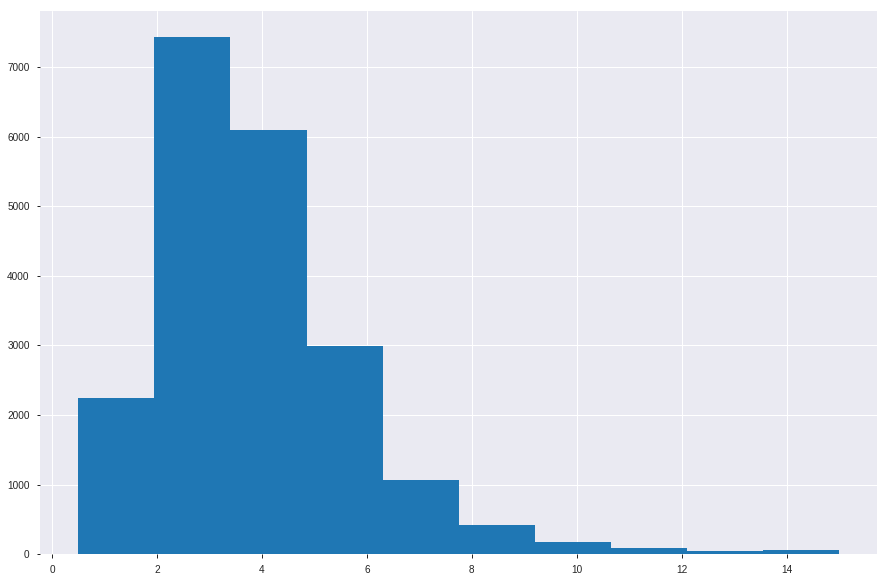

In [4]:
# Visualize median_income histogram
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(15, 10))
housing['median_income'].hist()

Most `median_income` values range between \$15,000 and \$60,000 with some values in the right tail. One way to address this skew is to categorize ranges of income values in an attempt to normalize (i.e. make closer to a bell curve) the distribution.

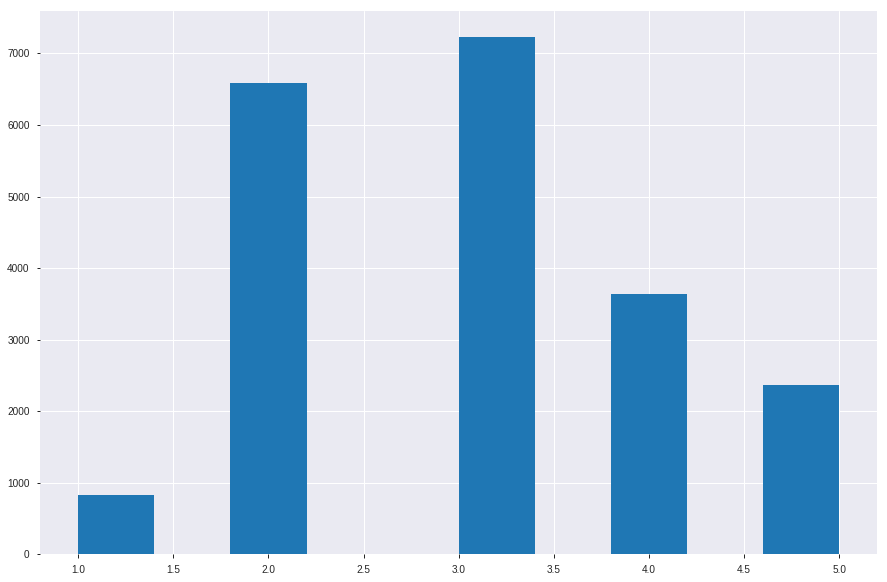

In [5]:
# Create income_cat feature with five strata for income ranges 
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Visualize income_cat histogram
plt.figure(figsize=(15, 10))
housing['income_cat'].hist()

Using Scikit-Learn's `StratifiedShuffleSplit` function, the training and testing data sets can be generated to ensure the `median_income` feature is representative in each split.



In [0]:
# Generate stratified training and testing data sets
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, 
                               test_size=0.2, 
                               random_state=734)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In order to make sure the stratification and split worked correctly, a simple data frame can be constructed to compare the proportions of median incomes across the five categories between the random test split and the stratified test split.

In [8]:
# Create function for calculating category proportions
def income_cat_proportions(data):
    return data['income_cat'].value_counts() / len(data)

# Generate random 80/20 training and testing data sets
train_set, test_set = train_test_split(housing, 
                                       test_size=0.2, 
                                       random_state=734)

# Generate data frame to compare each technique
compare_props = pd.DataFrame({
    'Overall': income_cat_proportions(housing),
    'Stratified': income_cat_proportions(strat_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()

compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.038033,-4.501217,-0.243309
2,0.318847,0.318798,0.316376,-0.774958,-0.015195
3,0.350581,0.350533,0.348837,-0.497512,-0.013820
4,0.176308,0.176357,0.177810,0.851882,0.027480
5,0.114438,0.114583,0.118944,3.937341,0.127011


Although not *exactly* the same proportions, the stratified split is very close to the proportions in the full data set. The new `income_cat` feature will be deleted so the data sets are back to their original sets of features while still keeping stratification in place.

In [0]:
# Drop income_cat feature from both training and testing data sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', 
              axis=1, 
              inplace=True)

### Explore and visualize data
Histograms are a good utility visualization but can be limited (and they don't work at all for categorical or geographic data). Since this machine learning project is based on real estate, it might be a good idea to explore the geographic data as it relates to the `median_house_value` label to see if anything interesting pops up.

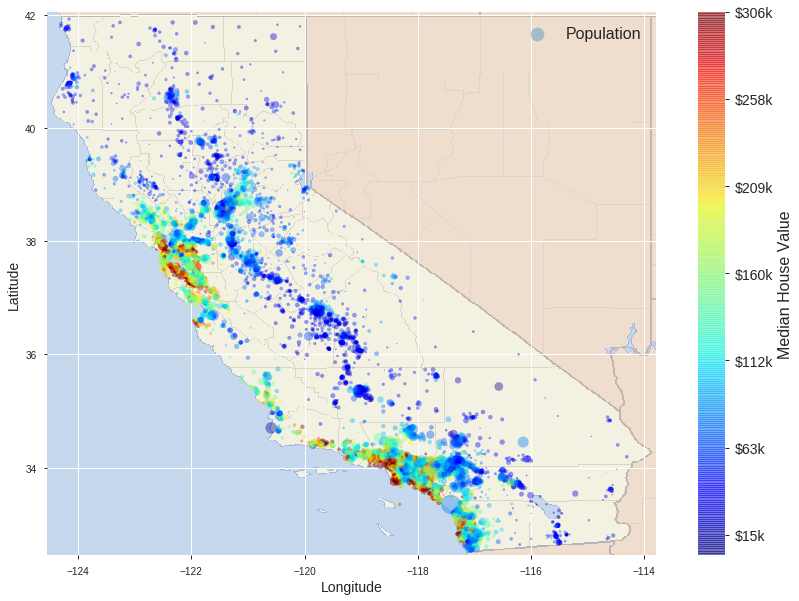

In [10]:
# Plot districts by lat/long with median_house_price colored
import matplotlib.image as mpimg

housing = strat_train_set.copy() # This just creates a copy of the training data
california_img = mpimg.imread('https://raw.githubusercontent.com/jsukup/handson-ml2/master/images/end_to_end_project/california.png')

ax = housing.plot(kind='scatter', 
                  x='longitude', 
                  y='latitude', 
                  figsize=(15, 10),
                  s=housing['population']/100, 
                  label='Population',
                  c='median_house_value', 
                  cmap=plt.get_cmap('jet'),
                  colorbar=False, 
                  alpha=0.4)

plt.imshow(california_img, 
           extent=[-124.55, -113.80, 32.45, 42.05], 
           alpha=0.5,
           cmap=plt.get_cmap('jet'))

plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)

plt.show()

## Q: What are some of the insights this visualization provides about `median_house_value`?
## A: [TYPE ANSWER HERE]


### Feature engineering
Identifying relationships between features and between features and the label is an important **exploratory data analysis** task. Correlation statistics provide a measure of the strength of relationships between features and were already visualized earlier with the `pandas_profiling` package. Strong relationships between features and labels can indicate features important to model training later on. This may also help to eliminate features from the data that aren't helpful, thus reducing the size of our data set and potentially the computation time needed for model training. This is called **feature selection**.

Feature engineering also includes **feature extraction** where new features are created from existing ones. The data set contains three features that might be more useful if they were *household-level* measures rather than *district-level* -- `total_rooms`, `total_bedrooms`, and `population`. Creating and comparing the new features' correlations to `median_house_value` with the original features shows that all three have stronger relationships to the label.

In [11]:
# Create three new features for household-level measures
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

# Show correlations
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.690148
rooms_per_household         0.143555
total_rooms                 0.137426
housing_median_age          0.105142
households                  0.068182
total_bedrooms              0.051310
population                 -0.022455
population_per_household   -0.026668
longitude                  -0.048238
latitude                   -0.141827
bedrooms_per_room          -0.258100
Name: median_house_value, dtype: float64

### Data cleaning
Cleaning "messy" data is said to account for 80% of a data scientist's work load. This is not a very 'fun' part of machine learning solution building, so in the real-world it's advisable to build functions for these tasks and eventually create a repository you can use for future projects. Most of the cleaning steps for this data set are simple and won't require elaborate function coding.

First, create a new training data set that removes the label since sometimes the transformations applied during this stage shouldn't be applied to it.

In [0]:
# Create a new training data set and split labels into another object
housing = strat_train_set.drop('median_house_value', axis=1) 
housing_labels = strat_train_set['median_house_value'].copy()

Next, most machine learning algorithms won't work with missing data so they need to be addressed. There are multiple approaches to handling missing values including:
* Drop observations (rows) from the data containing a missing value
    - ```
    housing.dropna(subset=['total_bedrooms']) 
      ```
* Drop features (columns) from the data containing a missing value
    - ```
    housing.drop('total_bedrooms', axis=1)
      ```
* Impute missing values by setting them to some value like the feature mean, median, mode, etc.
    - ```
    median = housing['total_bedrooms'].median()
    housing['total_bedrooms'].fillna(median, inplace=True)
      ```

Scikit-learn also has built-in functions for dealing with missing values. The function `SimpleImputer` will replace missing values according to the `strategy=` argument. Note, that it only works on numeric features so `ocean_proximity` will have to be treated differently.


In [0]:
# Instantiate the SimpleImputer function and set strategy to 'median'
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Create new data set with ocean_proximity removed
housing_num = housing.drop('ocean_proximity', axis=1)

# Replace missing values with median
X = imputer.fit_transform(housing_num)

# Transform X from numpy array into data frame
housing_tr = pd.DataFrame(X, 
                          columns=housing_num.columns,
                          index=housing.index)

Before appending the `ocean_proximity` feature back to the data set, it needs to be transformed into a numeric feature. Computers operate with numbers so text is meaningless and needs to be converted to something it can read and understand when used in a ML algorithm. 

Categorical features can either be *nominal* or *ordinal*. Nominal features have no hierarchy meaning it can't be quantified how different the values are (e.g. hair colors). Ordinal features *do* have an inherent hierarchy (e.g. "Good", "Better", "Best"). It appears that `ocean_proximity` doesn't have a hierarchy so Scikit-Learn's `OneHotEncoder` can be used to create **dummy features**. Dummy features are binary features added to a data set for each value a categorical feature can take. `ocean_proximity` can take on five values so five new categorical features are created with a "1" assigned to the observation's given value for the original categorical feature and a "0" for all others (see below).

![](https://naadispeaks.files.wordpress.com/2018/04/mtimfxh.png?w=471&h=151)



In [14]:
# Create dummy features for ocean_proximity
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)

housing_cat = housing[['ocean_proximity']]
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# Print out category names and array
print(cat_encoder.categories_)
print(housing_cat_1hot)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


Pipelines in machine learning solutions can streamline the tasks performed up to this point an beyond. So far, all tasks have been performed piecemeal but Scikit-Learn provides several built-in tools for combining these operations into custom-made classes.

Scikit-Learn's API is designed using consistent object characteristics:
* *Estimators* are objects that can estimate (or *learn*) parameters from a data set. This is the goal of all machine learning algorithms -- learn the parameters of a model that best describe the relationship between features and (in supervised learning) labels. When the `.fit()` method is called, an estimator is being implemented.
* *Transformers* are objects that transform a data set's values. Sometimes this transformation is based on the results of an estimator's learned parameters. When the `.transform()` method is called, the values in a data set are being transformed. Transformers also have a `.fit_transform()` method that applies both estimation and transformation sequentially.
* *Predictors* take an existing model (typically learned with an estimator) and use it to make predictions with new data. When the `.predict()` method is called, a predictor is being used to estimate values using a model. They also have a `.score()` method for measuring the quality of predictions when compared to actual labels in a test set (for supervised learning problems).

Below, a class is made called `CombinedAttrAdder` which calculates the two (or three depending on whether or not `add_bedrooms_per_room` is set to `True`) additional features created earlier to transform district-level features to household-level ones. It is then instantiated in the object `attr_adder` and applied (using the `.transform()` method) to the `housing` data set and saved in the `housing_extra_attribs` object.


In [15]:
# Import base estimator and transformer functions
from sklearn.base import BaseEstimator, TransformerMixin

# Column indices in housing object for features needed
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# Feature extraction
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Apply transformation to data.
# If `add_bedrooms_per_room` set to 'False', remove 'bedrooms_per_room' column 
# from dataframe
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True) 
housing_extra_attribs = attr_adder.transform(housing.values)

# Create new dataframe with extracted features
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+['rooms_per_household', 'population_per_household','bedrooms_per_room'],
    index=housing.index)

# Inspect top five rows of new dataframe
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
512,-122.23,37.82,52,3242,366,1001,352,12.2138,NEAR BAY,9.21023,2.84375,0.112893
18323,-122.13,37.44,43,3004,440,1088,427,9.1508,NEAR BAY,7.03513,2.54801,0.146471
15696,-122.45,37.79,52,1734,482,731,429,1.4804,NEAR BAY,4.04196,1.70396,0.27797
2728,-115.55,32.79,23,1004,221,697,201,1.6351,INLAND,4.99502,3.46766,0.22012
13593,-117.28,34.11,39,1573,418,1258,359,1.4896,INLAND,4.38162,3.50418,0.265734


### Feature scaling
Measurement scales across features in a data set are often different. Most machine learning algorithms do not perform well when this is the case since they rely on calculating *distances* between observations for estimating similarity or difference. The California Housing Data set is no exception. For example, the range of values for `total_rooms` is from 6 to 39,320 while the range for `median_income` is just 0 to 15 (note that label values are generally never scaled). 

Two approaches for handling feature scaling are **Normalization** (or **Min-Max Scaling**) and **Standardization**. Normalization scales features to fall withing the range 0 and 1 according to the following:

$$\LARGE
x'=\frac{x_i-X_{min}}{X_{max}-X_{min}}
$$

Standardization transforms features to have a mean of 0 and a standard deviation of 1, essentially giving it a normal distribution. Normally distributed features usually 'play well' with machine learning algorithms. Unlike normalization, feature values are not constrained between 0 and 1. Standardization is also less influenced by outliers compared to normalization. Standardization can be formulated as:

$$\LARGE
x'=\frac{x_i-X_\mu}{X_\sigma}
$$

Scikit-Learn provides built-in functions for both scaling techniques. `StandardScaler` applies standardization which is the approach applied below within the context of a simple pipline created using the Scikit-Learn `Pipeline` function. This pipeline applies imputation of missing values, feature extraction using the class created earlier, and standardization. This pipeline only applies to *numeric* features in the data set so `ocean_proximity` will need to be addressed separately. 

In [0]:
# Create pipeline for numeric feature preparation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Pass numeric features through pipeline
housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipelines in Scikit-Learn take a list of name/estimator pairs that define the sequence of data preparation tasks. All but the final estimator needs to have a `transform()` method as well. When executing a pipeline the `.fit_transform()` method is automatically called for all intermediary estimators before passing the output to the next estimator.

For convenience, it makes sense to combine pipelines for handling *both* numeric and categorical features together. The Scikit-Learn class `ColumnTransformer` allows for this.

In [17]:
# Create combined numeric and categorical pipeline
from sklearn.compose import ColumnTransformer

# Extract names of numeric and categorical columns
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs)
])

# Pass all features through pipeline
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape # Rows x columns

(16512, 16)

`ColumnTransformer` works by taking the names of numeric feature columns and applying the first pipeline to just those columns. Then it applies the one transformation we did previously to the `ocean_proximity` feature, `OneHotEncoding`. When applied, the final prepared data set contains 16512 rows and 16 columns.

## Modeling
In this stage a model is trained on the training data to learn the parameters of the model that best describe the relationship between features and labels. Noted earlier, it typically only accounts for ~20% of the data scientist's time on a project but that could fluctuate based on the complexity of the problem or if a custom model needs to be trained.

### Train model on training data
First, train a linear regression model. This is the same model used earlier in the "Model-based Learning" lab. Training most models using Scikit-Learn only requires two lines of code if all the model's hyperparameters are left at their defaults (which typically are good enough for initial model training and evaluation).

In [18]:
# Train a linear regression model on preprocessed housing data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Test model predictions with performance metric
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

# Just for fun, also check MAE
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
print('RMSE:', lin_rmse, 'MAE:', lin_mae)

RMSE: 68218.59722228849 MAE: 49276.37841504166


Comparing the model's predictions to the actual values shows that it isn't working all that well -- in some cases being off by hundreds of thousands of dollars. Both the RMSE and MAE errors are fairly substantial and probably wouldn't be acceptable in a real-world application for the real estate company's investment team.

Since this model was tested using the *training data* set (i.e. the same data used to train the model), these poor performance scores indicate that the model is **underfitting** -- the opposite of **overfitting** -- meaning the model is not complex enough to capture the underlying relationship between the features and labels.

A different model, a **Decision Tree** is trained below (this model hasn't been discussed yet)

In [19]:
# Train a decision tree model on preprocessed housing data
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=734)
tree_reg.fit(housing_prepared, housing_labels)

# Test model predictions with performance metric
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(housing_labels, housing_predictions)
print('RMSE:', tree_rmse, 'MAE:', tree_mae)

RMSE: 0.0 MAE: 0.0


WOW! A model with zero error? How is that possible? It's much more likely that the model is horribly overfitting the data (remember, the data being used to *test* the model's performance is the same data used to *train* it). 

### Evaluating using cross-validation
Rather than use the training data for both training and testing, **cross-validation** is a better approach for estimating model performance. The `test_train_split` function has already been showcased but oftentimes **K-fold Cross-validation** is a better alternative. The way it works is by first splitting the data set into "K" number of partitions, or "folds." Then it trains and evaluates a model K-times picking a different fold for evaluation each time while training the remaining K-folds. So, if "10" is chosen for the value of "K," 10 folds will be created and 10 models will be trained/evaluated. Then, the average is taken across each performance measure (i.e. RMSE). This is a method for smoothing out the performance metric estimation.

In [20]:
# Cross-validate the decision tree model 
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, 
                         housing_prepared, 
                         housing_labels,
                         scoring='neg_mean_squared_error', 
                         cv=10) # Select 10 folds

# Calculate RMSE across scores
tree_rmse_scores = np.sqrt(-scores)

# Print scores
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

display_scores(tree_rmse_scores)

Scores: [66867.65669154 67644.76683791 69746.92032814 66270.24071757
 72244.94313627 67872.43195816 67418.84568692 74584.9327082
 70053.17975289 69859.56739889]
Mean: 69256.34852164904
Standard deviation: 2471.366153535938


According to the cross-validation scores, on average the model's predictions are off by \$69,649 which is probably not acceptable. This also confirms that the decision tree model is most likely overfitting on the training data. Compare to linear regression cross-validation performance metrics: 

In [21]:
# Cross-validate the linear regression model
lin_scores = cross_val_score(lin_reg, 
                             housing_prepared, 
                             housing_labels,
                             scoring='neg_mean_squared_error', 
                             cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [68575.11612625 69398.02824992 69145.89314424 71582.89888058
 68291.55381426 67605.48884345 63684.39056369 72007.01838674
 67693.94703009 67947.19709077]
Mean: 68593.15321299879
Standard deviation: 2189.405172577601


Also an unacceptable performance score. Thankfully, there are numerous models available (and *tuning techniques*) for training better models than these two. **RandomForestRegressor** is like building multiple, but slightly different, decision trees and is what is referred to as an **Ensemble Method** because it aggregates predictions across multiple models.

In [22]:
# Train a random forest model on preprocessed housing data
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=734)
forest_reg.fit(housing_prepared, housing_labels)

# Test model predictions with performance metric
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

print('RMSE:', forest_rmse)

RMSE: 18388.542835849505


Substantially better performance than a single decision tree model. Using cross-validation the performance estimate should be more precise.

In [23]:
# Cross-validate the Random Forest model 
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, 
                                housing_prepared, 
                                housing_labels,
                                scoring='neg_mean_squared_error', 
                                cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

KeyboardInterrupt: ignored

The Random Forest model still performs better than both linear regression and a decision tree, but the average error after cross-validation is fairly large. 

### Create shortlist of candidate models
Remember, when building machine learning solutions there is no "magic bullet" in terms of best-performing models. It's never known which ML algorithm is going to work best. This is called the **No Free Lunch Theory** and is the rationale behind training and choosing several candidate models before moving them to the Evaluation stage. For the sake of time, the Random Forest model will be the only one considered in the Evaluation stage.

## Evaluation
The Evlaution stage is where a set of potentially viable models from the previous stage, Modeling, are fine-tuned to achieve the best performance before a final evaluation on the test set.

### Hyperparameter optimization
In ML, algorithms attempt to find the best parameters of a model (basically a mathematical formalization, or equation) that captures the relationship between features and their labels. Hyperparameters, or tuning parameters on the other hand, tell the model *how* to train. This typically applies constraints to model training that can both improve predictive performance and limit overfitting.

One way to find a model's optimal hyperparamaters would be to manually train several models with different hyperparameters and see which on gives the best performance scores. Yet this could become quickly inefficient as the number of hyperparameters available to try becomes large. **Grid search** is one approach for handling hyperparameter optimization. Grid search works by being provided a set of possible hyperparameters to try, then builds an exhaustive set of models using every combination of hyperparameters. 


In [0]:
# Train a Random Forest model using grid search with cross-validation
from sklearn.model_selection import GridSearchCV

# Create a list of hyperparameter values set as key:value pairs
param_grid = [
    # Try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # Try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

# Train Random Forest model
forest_reg = RandomForestRegressor(random_state=734)

# Five fold cross-validation: (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Fit model to training data
grid_search.fit(housing_prepared, housing_labels)

# Print best parameters and estimator
print('Best parameters:', grid_search.best_params_, '\n',
      'Best estimator:', grid_search.best_estimator_)

Even with just one base model, Random Forest (and not even playing with all available hyperparameters for Random Forest), 90 different models are trained. The resulting best model (i.e. the model with the lowest MSE) has `bootstrap=True`, `max_features=6`, and `n_estimators=30`. Look at the score of each hyperparameter combination tested during the grid search:

In [0]:
# Inspect metrics for top 5 models and sort best to worst
pd.DataFrame(grid_search.cv_results_).sort_values(['rank_test_score'], ascending=True)[:5]

**Random search** is another technique for finding the best hyperparameters of a model. Unlike grid search, random search does *not* try exhaustive combinations of hyperparameters but instead, as the name implies, tries randomized combinations (rather than setting an explicit set of hyperparameter values, a *range* is given for the algorithm to choose from). This works well when large numbers of hyperparameters are being tuned and can provide comparible results to grid search as well.

In [0]:
# Train a Random Forest model using random search with cross-validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Create a range of hyperparameter values set as key:value pairs
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
}
# Train Random Forest model
forest_reg = RandomForestRegressor(random_state=734)

# Five fold cross-validation: 10 iterations using random hyperparameters
rnd_search = RandomizedSearchCV(forest_reg, 
                                param_distributions=param_distribs,
                                n_iter=10, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                random_state=734)

# Fit model to training data
rnd_search.fit(housing_prepared, housing_labels)

# Print best parameters and estimator
print('Best parameters:', rnd_search.best_params_, '\n',
      'Best estimator:', rnd_search.best_estimator_)

In [0]:
# Inspect metrics for top 5 models and sort best to worst
pd.DataFrame(rnd_search.cv_results_).sort_values(['rank_test_score'], ascending=True)[:5]

### Ensemble methods
Another way to fine-tune models during the Evaluation stage is to combine the predictions of several best-performing models. **Ensemble methods** do just this and Random Forest is an example of this technique. Ensembles tend to smooth out prediction estimations similar to getting a second test or second opinion when going to the doctor. Ensemble methods won't be covered in detail in this course.

Before going further, Random Forest can provide information on which features contribute the most to accurate predictions. This information can also be useful for determining if any features can be dropped if they are not that helpful in making predictions.

In [0]:
# Print feature important scores
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
features = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, features), reverse=True)

### Evaluate best performing model on test set
When satisfied with what is set to be the final model, the test set is used to evaluate. Remember, the test set hasn't been used at all in the training of the model. This is to *simulate* the model's performance on data it will encounter in its production environment.

In [0]:
# Test final model on test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('Final Model MSE:', final_rmse)

Performance is typically slightly worse on the test set than what was measured during cross-validation. However, the data scientist should resist the temptation of going back and tuning hyperparameters after seeing the test set performance as this will inevitably start to overfit the model and start to train it on the idiosyncracies of the test data.

## Deployment
At this point, model training and testing is complete! But this is really only half-way to calling the ML solution "done." Next is the Deployment stage which typically requires the data scientist to exhaustively report on the model training process (i.e. lessons learned, what worked/didn't work, assumptions made, system limitations, etc.). Again, Jupyter Notebooks are very helpful and widely-used for these purposes. 

## Q: What was learned specifically about this model in comparison to the previous approach for estimating California median house prices (i.e. expert estimation)?
## A: [TYPE ANSWER HERE]

The data scientist (or team of data scientists) typically need to *sell* their solution to executives and decision makers prior to productionizing. With approval to launch, the data scientist will typically start to pass off the solution to a **machine learning engineer** responsible for deployment to the end-user. They are tasked with determining how best to deliver the model with considerations on how it will be hosted (i.e. cloud or on-prem) and associated costs. 

Along with the data scientist, maintenance systems should be provisioned to monitor model performance over time as models tend to degrade. Not only does this mean monitoring the model, but also the input data. This is *especially* important for **online learning** systems that train models continuously.

### Congats! That's a complete machine learning pipeline solution!

## Exercises

Try fitting different models with the techiques just used. 

**NOTE:**
* Always set `random_state=734` when applicable so everyone obtains the same answers
* Setting the menu item *Runtime-->Change runtime type* to **GPU** or **TPU** can improve speed

### Q1: 
Try a **Support Vector Machine** regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel='linear'` (with 3 values for the `C` hyperparameter) and `kernel='rbf'` (with 3 values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. 

How does the best `SVR` predictor perform? Print the best model's RMSE and parameters.  

In [0]:
# Train a Support Vector Machine using grid search to find the best parameters
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Create a list of hyperparameter values set as key:value pairs
param_grid = [
        {'kernel': ['linear'], 'C': [10., 3000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 30., 1000.0],
         'gamma': [0.01, 0.3, 3.0]},
]

# Train Support Vector Machine model
svm_reg = SVR()

# Five fold cross-validation: (3+9)*5=60 rounds of training 
grid_search_SVR = GridSearchCV(svm_reg, 
                               param_grid, 
                               cv=5, 
                               scoring='neg_mean_squared_error',
                               verbose=2,
                               n_jobs=-1)

# Fit model to training data
grid_search_SVR.fit(housing_prepared, housing_labels)

# Calculate RMSE
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)

# Print best parameters and estimator
print('Best RMSE:', rmse, '\n',
      'Best parameters:', grid_search_SVR.best_params_)

### Q2:
Try replacing `GridSearchCV` with `RandomizedSearchCV` and set `n_iter=10`  and `cv=5`. Print the best model's RMSE and parameters.

In [0]:
# Try random search with Support Vector Machine model
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability 
# distribution functions.

# Create a range of hyperparameter values set as key:value pairs
# Note: gamma is ignored when kernel is 'linear'
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
}

# Train Support Vector Machine model
svm_reg = SVR()

# Five fold cross-validation: 20 iterations using random hyperparameters
rnd_search_SVR = RandomizedSearchCV(svm_reg, 
                                    param_distributions=param_distribs,
                                    n_iter=10, 
                                    cv=5, 
                                    scoring='neg_mean_squared_error',
                                    verbose=2,
                                    n_jobs=-1)

# Fit model to training data
rnd_search_SVR.fit(housing_prepared, housing_labels)

# Calculate RMSE
negative_mse = rnd_search_SVR.best_score_
rmse = np.sqrt(-negative_mse)

# Print best parameters and estimator
print('Best RMSE:', rmse, '\n',
      'Best parameters:', rnd_search_SVR.best_params_)

### Q3:
Try adding a transformer class in the preparation pipeline to select only the most important features.

(**NOTE**: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/random search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# Use RandomForestRegressor to compute feature importance scores
# feature_importances = xxx
# attributes = xxx

# Create function to sort feature importances descending
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

# Create new class 'TopFeatureSelector' for selecting important features
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

# Set the number of features to keep as the top 5
k = 5

# Find indices of top 5 features
top_k_feature_indices = indices_of_top_k(feature_importances, k)

# Transform feature names into Numpy array
np.array(attributes)[top_k_feature_indices]
sorted(zip(feature_importances, attributes), reverse=True)[:k]

# Create pipeline that incorporates TopFeatureSelector
pipeline = Pipeline([
                     ('preparation', full_pipeline),
                     ('feature_selection', TopFeatureSelector(feature_importances, k))
])

# Fit model to training data via pipeline
housing_prepared_top_k_features = pipeline.fit_transform(housing)

# Print out feature of top three observations
housing_prepared_top_k_features[0:3]

### Q4:
Try creating a single pipeline that does the full data preprocessing plus the final prediction. This can be accomplished using the original `full_pipeline` created earlier, the `TopFeatureSelector` class, and the `SVR` model.

Try the pipeline on a few observations from the training data.

In [0]:
# Create final pipeline for preprocessing and prediction
final_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

# Fit model to training data
final_pipeline.fit(housing, housing_labels)

# Print the prediction and actual label on the
# first four observations of the training data set
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]
print('Predictions:\t', final_pipeline.predict(some_data))
print('Labels:\t\t', list(some_labels))

### Q5:
Automatically explore some preprocessing options using `GridSearchCV` on the `final_pipeline` just created. Print out the parameters of the best model

To access hyperparameters nested within other pipelines, double underscores (i.e. "\__") can be used. For example, to tune the value of `k` in the `TopFeatureSelector` class, set the pipeline key:value pair to `'feature_selector__k'`followed by some method for generating values for `k`. 

Double underscores allow access to nested tasks within the pipeline. Another example: to access the `SimpleImputer` nested all the way down in the first pipeline created for numeric features alone (i.e. `num_pipeline`), use the names given to each pipeline object in sequence:

```
'preparation__num__imputer__strategy'
```
where:
```
preparation__ = [name for `full_pipeline` in `final_pipeline`]
num__ = [name for `num_pipeline` in `full_pipeline`]
imputer__ = [name for `SimpleImputer` in `num_pipeline`]
strategy = [hyperparameter for `SimpleImputer`]
```



In [0]:
# Create grid search parameters for pipeline
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

# Five fold cross-validation: (4+16)*5=100 rounds of training  
grid_search_prep = GridSearchCV(final_pipeline, 
                                param_grid, 
                                cv=5,
                                scoring='neg_mean_squared_error')

# Fit model to training data
grid_search_prep.fit(housing, housing_labels)

print(grid_search_prep.best_params_)